In [ ]:
! git clone https://github.com/allenai/VILA

Cloning into 'VILA'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (441/441), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 653 (delta 239), reused 343 (delta 189), pack-reused 212
Receiving objects: 100% (653/653), 7.91 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (307/307), done.


In [ ]:
%cd VILA

/content/VILA


In [ ]:
%%capture
!pip install -e . # Install the `vila` library

In [ ]:
%%capture
! pip install -r requirements.txt

In [ ]:
%%capture
! apt-get install poppler-utils 

In [28]:
! pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 52.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [1]:
import layoutparser as lp # For visualization 

from vila.pdftools.pdf_extractor import PDFExtractor
from vila.predictors import HierarchicalPDFPredictor

pdf_extractor = PDFExtractor("pdfplumber")
vision_model = lp.EfficientDetLayoutModel("lp://PubLayNet") 
pdf_predictor = HierarchicalPDFPredictor.from_pretrained("allenai/hvila-block-layoutlm-finetuned-docbank")

In [2]:
page_tokens, page_images = pdf_extractor.load_tokens_and_image(f"doc3.pdf")

In [3]:
idx = 1
page_image = page_images[idx]
page_token = page_tokens[idx]

blocks = vision_model.detect(page_image)
page_token.annotate(blocks=blocks)
pdf_data = page_token.to_pagedata().to_dataframe()

In [4]:
pdf_data.head()

,id,x_1,y_1,x_2,y_2,text,category,block_id,line_id,is_block,is_line
0,0,305.365723,348.173248,326.337463,355.893372,None,Title,-1.0,-1,True,False
1,1,39.925980,368.785095,114.925415,377.879303,None,Title,-1.0,-1,True,False
2,2,35.087124,386.837799,290.298306,647.645996,None,Text,-1.0,-1,True,False
3,3,35.911415,650.103149,289.209663,742.394287,None,Text,-1.0,-1,True,False
4,4,306.787903,520.651794,557.699280,727.787659,None,Text,-1.0,-1,True,False


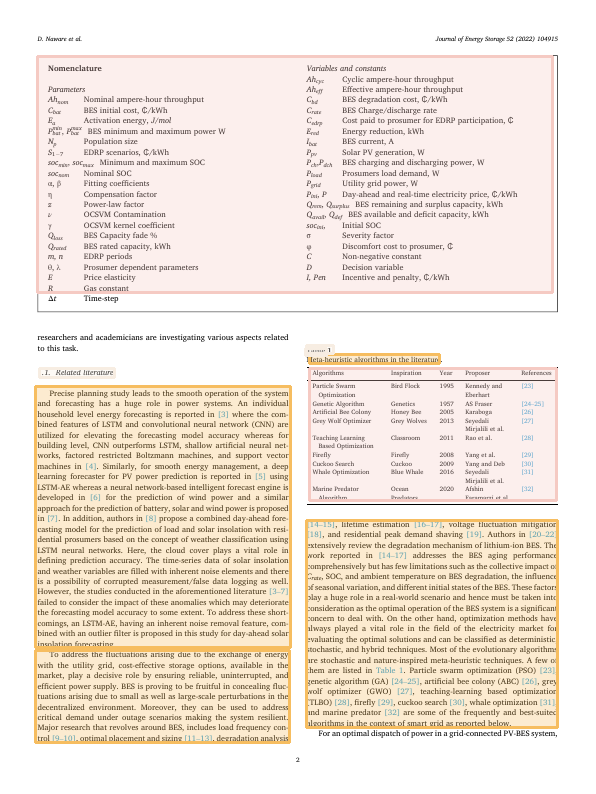

In [ ]:
lp.draw_box(page_image, blocks, box_width=3,box_alpha=0.30)

In [15]:
blocks_list = []
blocks_list_verts = []
blocks_list_verts_x = []

id = 0
for b in blocks._blocks:
  block = b.block
  x1 = block.x_1
  y1 = block.y_1
  x2 = block.x_2
  y2 = block.y_2

  d = {}
  d['description'] = id
  d['vertices'] = [(x1,y1),(x2,y1),(x2,y2),(x1,y2)]
  d['coords'] = [x1,y1,x2,y2]
  blocks_list.append(d)
  blocks_list_verts_x.append([x1,x2])
  blocks_list_verts.append([x1,y1,x2,y2])
  id += 1

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

model = AgglomerativeClustering(n_clusters=None, linkage="single", metric='l1', distance_threshold=200)
model.fit_predict(blocks_list_verts_x)

array([1, 0, 0, 1, 2, 0, 1, 1, 1])

In [37]:
def merge_bounding_boxes(cluster_labels, measurements):
    merged_boxes = {}
    for label, measure in zip(cluster_labels, measurements):
        if label not in merged_boxes:
            merged_boxes[label] = measure
        else:
            merged_boxes[label] = [min(x, y) if i < 2 else max(x, y) for i, (x, y) in enumerate(zip(merged_boxes[label], measure))]
    return merged_boxes

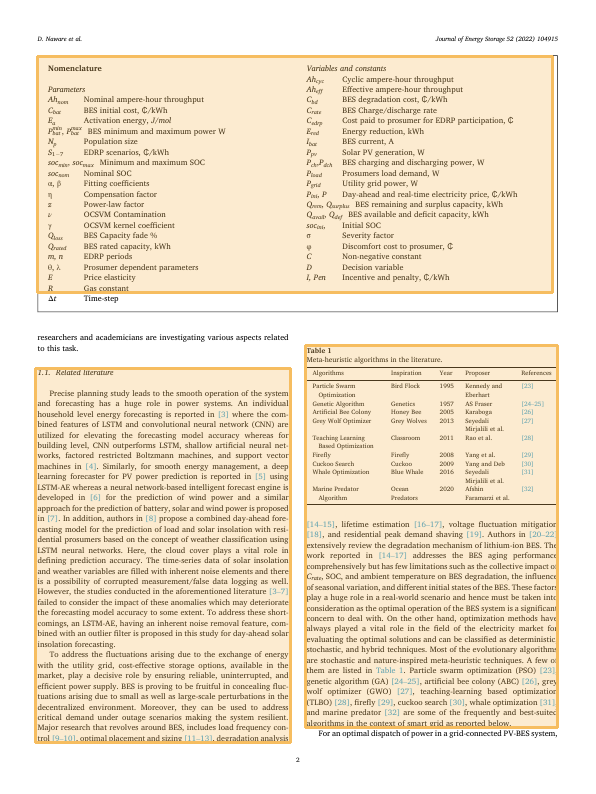

In [42]:
clustered_bbox = merge_bounding_boxes(model.labels_, blocks_list_verts).values()
reconstructed_layout = lp.Layout([       
              lp.TextBlock(
                  lp.Rectangle(float(ele[0]), float(ele[1]), 
                              float(ele[2]), float(ele[3])),
                  text=None,
                  id = idx
              ) for idx, ele in enumerate(clustered_bbox)
          ])

lp.draw_box(page_image, reconstructed_layout, box_width=3,box_alpha=0.30)

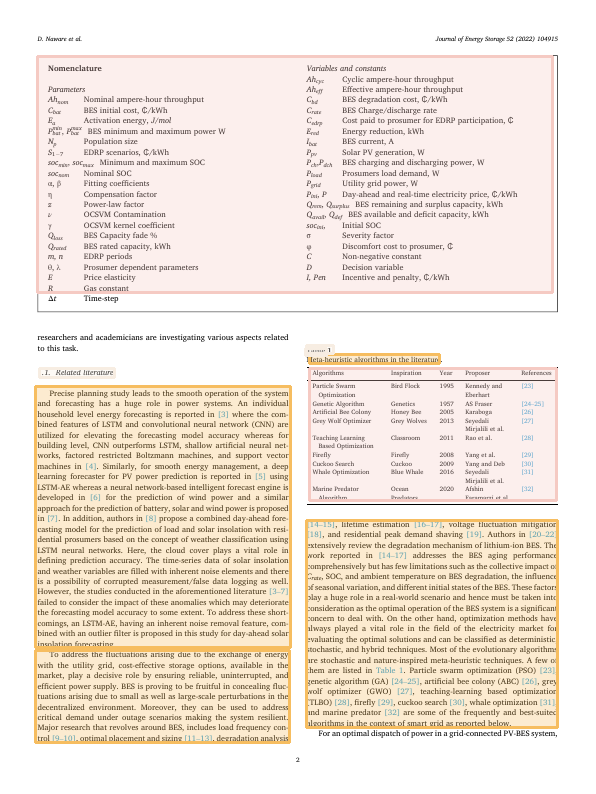

In [43]:
lp.draw_box(page_image, blocks, box_width=3,box_alpha=0.30)

In [13]:
pairwise_distances(blocks_list_verts, metric='l1')

array([[  0.        , 539.36610413, 539.10175323,   3.91784668,
        274.57341003, 709.63578796, 121.27508545, 224.65826416,
        232.78399658],
       [539.36610413,   0.        ,   1.91293335, 540.473526  ,
        264.79269409, 178.29881287, 423.77949524, 314.70783997,
        306.58210754],
       [539.10175323,   1.91293335,   0.        , 540.20917511,
        264.5283432 , 180.21174622, 423.51514435, 314.44348907,
        306.31775665],
       [  3.91784668, 540.473526  , 540.20917511,   0.        ,
        275.68083191, 710.74320984, 117.35723877, 225.76568604,
        233.89141846],
       [274.57341003, 264.79269409, 264.5283432 , 275.68083191,
          0.        , 439.48298645, 384.84613037, 487.83911133,
        493.51068115],
       [709.63578796, 178.29881287, 180.21174622, 710.74320984,
        439.48298645,   0.        , 594.04917908, 484.9775238 ,
        476.85179138],
       [121.27508545, 423.77949524, 423.51514435, 117.35723877,
        384.84613037, 594.0491

In [41]:
# pairs = []
# threshold_y = 100 # height threshold
# threshold_x = 10 # x threshold

# for i in range(len(blocks_list)):
#     for j in range(i+1, len(blocks_list)):
#         # left_upi, right_upi, right_lowi, left_lowi = blocks_list[i]['vertices']
#         # left_upj, right_upj, right_lowj, left_lowj = blocks_list[j]['vertices']
#         x1i, x2i, y1i, y2i = blocks_list[i]['orig_verts']
#         x1j, x2j, y1j, y2j = blocks_list[j]['orig_verts']

#         i_width = abs(x1i - x2i)
#         j_width = abs(x1j - x2j)

#         # threshold_x = 
#         cond1 = (abs(x1i - x1j) < threshold_x)
#         cond2 = (abs(x2i - x2j) < threshold_x)
        
#         # cond3 = (abs(y1i - y1j) < threshold_y)
#         # cond4 = (abs(y2i - y2j) < threshold_y)
        
#         if cond1 and cond2: #and (cond3 or cond4):
#             pairs.append([i,j])

In [ ]:
def annotate_and_predict(idx, page_tokens, page_images):
  page_token = page_tokens[idx]
  page_image = page_images[idx]

  blocks = vision_model.detect(page_image)
  page_token = page_tokens[idx]
  page_token.annotate(blocks=blocks)
  pdf_data = page_token.to_pagedata().to_dict()
  
  predicted_tokens = pdf_predictor.predict(pdf_data, page_token.page_size)
  return predicted_tokens, blocks, page_token.to_pagedata().to_dataframe()

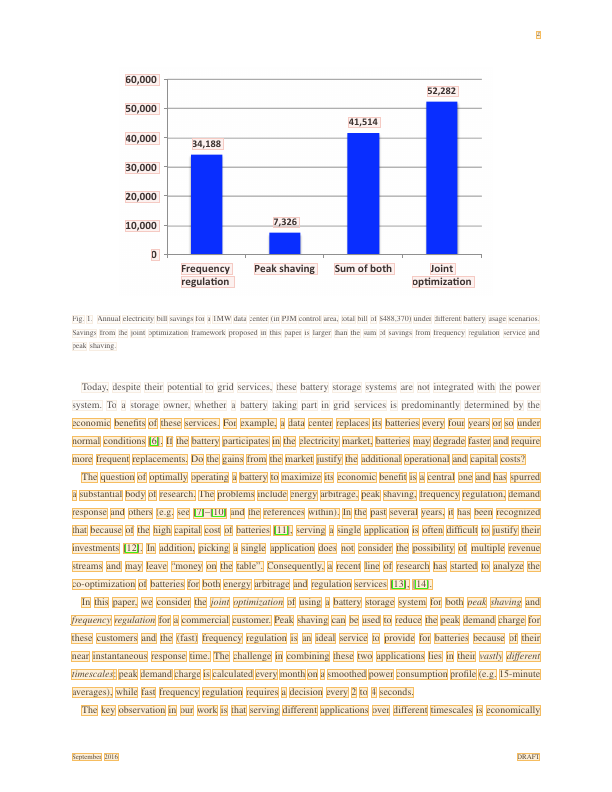

In [ ]:
idx = 1
predicted_tokens, blocks, pdf_data = annotate_and_predict(idx, page_tokens, page_images)
lp.draw_box(page_images[idx], predicted_tokens, box_width=1, box_alpha=0.25)

In [ ]:
# predicted_tokens